# Data Analysis using XGBoost

In [1]:
%pylab inline
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lib import XGBHelper as xgbh
import pandas as pd

from lib.logger import logger
xgb.__version__

Populating the interactive namespace from numpy and matplotlib


'1.5.0'

In [2]:
dir = '/net/birdstore/Active_Atlas_Data/cell_segmentation/DK55/all_features_modified.csv'
df = pd.read_csv(dir)
drops = ['animal', 'section', 'index', 'row', 'col'] 
df=df.drop(drops,axis=1)
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [3]:
def createDM(df):
    labels=df['label']
    features=df.drop('label',axis=1)
    return xgb.DMatrix(features, label=labels)

def split_data(df,frac=0.5):
    train = pd.DataFrame(df.sample(frac = 0.5))
    test = df.drop(train.index,axis=0)
    print(train.shape,test.shape,train.index.shape,df.shape)

    trainDM=createDM(train)
    testDM=createDM(test)
    AllDM=createDM(df)
    return trainDM,testDM,AllDM
 

## Setting Parameters for XG Boost
* Maximum Depth of the Tree = 3 _(maximum depth of each decision trees)_
* Step size shrinkage used in update to prevents overfitting = 0.3 _(how to weigh trees in subsequent iterations)_
* Maximum Number of Iterations = 1000 _(total number trees for boosting)_
* Early Stop if score on Validation does not improve for 5 iterations

[Full description of options](https://xgboost.readthedocs.io/en/latest//parameter.html)

In [4]:
# %load lib/Logger.py
import pandas as pd

class logger:
    """A helper class for defining a logger function and for parsing the
log, assuming it is created by XGBoost.
    Typical use:

    Logger=logger()
    logall=Logger.get_logger()

    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False, callbacks=[logall])
    D=Logger.parse_log() #returns a dataframe with the logs.
    """
    def __init__(self):
        self.log=[]
         
    def get_logger(self):
        def logall(*argv,**argc):
            self.log.append(*argv)
        return logall

    def parse_log(self,ax=None):
        """ parse the log and generate plots"""
        D={'iter':[]}
        for _env in self.log:
            current_err={key:val for key,val in _env.evaluation_result_list}
            D['iter'].append(_env.iteration)
            for k in current_err.keys():
                if k in D:
                    D[k].append(current_err[k])
                else:
                    D[k]=[current_err[k]]
        for k in list(D.keys()):
            if len(D[k])==0:
                del D[k]

        df=pd.DataFrame(D)
        df=df.set_index('iter')
        test_col=[c for c in df.columns if 'eval' in c][0]
        print('test column=',test_col)
        _min=df[test_col].min()
        index_min=df[test_col].idxmin()
        title='min of %s=%f at %d'%(test_col,_min,index_min)
        if not ax is None:
            df.plot(grid=True,title=title,ax=ax)  
        return df


In [5]:
def test_xgboost(depth=1,num_round=100):
    param['max_depth']= depth   # depth of tree
    fig, axes = subplots(1,2,figsize=(12,5))
    i=0
    for _eval in ['error','logloss']:
        Logger=logger()
        logall=Logger.get_logger()  # Set logger to collect results
        param['eval_metric'] = _eval 
        bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False, callbacks=[logall])
        df=Logger.parse_log(ax=axes[i])
        i+=1
    return bst,Logger
   

## ROC graph
* Often false positive and false negatives have different cost.
* Different tradeoffs between false positives and false negatives can be gotten using different thresholds.
* The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a good way to visualize the tradeoffs. 

In [8]:
param={'max_depth': 4,
 'eta': 0.3,
 'objective': 'binary:logistic',
 'nthread': 50,
 'eval_metric': 'logloss'}

In [9]:
trainDM,testDM,allDM=split_data(df)
evallist = [(trainDM, 'train'), (testDM, 'eval')]
num_round=500
bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
y_pred.shape

(400612, 41) (400612, 41) (400612,) (801224, 41)


(400612,)

In [ ]:
y_test=testDM.get_label()

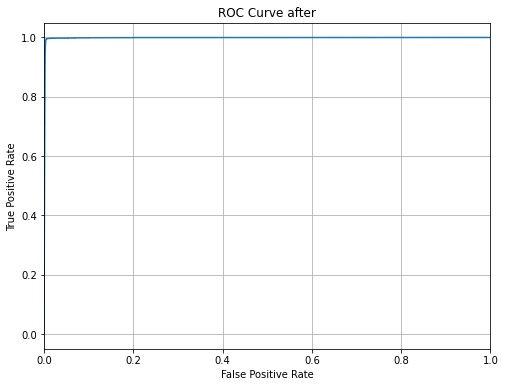

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve after")
plt.grid()
plt.show()

## Stability of the Margins.
Margins on the training set are predictive of margins of the test set, which is why margins are a better measure of performance than the training error.

In [ ]:
y_test=testDM.get_label()
pos_preds=y_pred[y_test==1]
neg_preds=y_pred[y_test==0]
pos_preds.shape,neg_preds.shape

((5564,), (395048,))

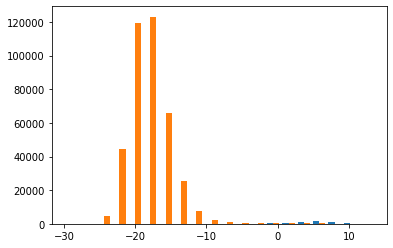

In [ ]:
plt.hist([pos_preds,neg_preds],bins=20);

In [16]:
def gen_scale(n,reverse=False):
    s=np.arange(0,1,1/n)
    while s.shape[0] !=n:
        if s.shape[0]>n:
            s=s[:n]
        if s.shape[0]<n:
            s=np.arange(0,1,1/(n+0.1))
    if reverse:
        s=s[-1::-1]
    return s

In [10]:
plt.figure(figsize=[15,8])
num_round=500
bst_list=[]
for i in range(30):
    trainDM,testDM,allDM=split_data(df)
    bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
    bst_list.append(bst)
    y_pred = bst.predict(testDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True)
    y_test=testDM.get_label()
    pos_preds=y_pred[y_test==1]
    neg_preds=y_pred[y_test==0]
    pos_preds=np.sort(pos_preds)
    neg_preds=np.sort(neg_preds)
    plt.plot(pos_preds,gen_scale(pos_preds.shape[0]));
    plt.plot(neg_preds,gen_scale(neg_preds.shape[0],reverse=True))
grid();

(400612, 41) (400612, 41) (400612,) (801224, 41)


NameError: name 'gen_scale' is not defined

<Figure size 1080x576 with 0 Axes>

In [ ]:
DATA_DIR='/data/cell_segmentation/'

In [11]:
import pickle as pk
with open(DATA_DIR+'BoostedTrees_r2.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh $DATA_DIR/*.pkl

-rw-rw-r-- 1 zhw272 dklab  51K Jan 11 10:48 /data/cell_segmentation//average_cell_image.pkl
-rw-r--r-- 1 zhw272 dklab 7.0M Jan 11 10:41 /data/cell_segmentation//BoostedTrees.pkl
-rw-r--r-- 1 zhw272 dklab 987K Jan 20 16:45 /data/cell_segmentation//BoostedTrees_r2.pkl


### Skip to here for testing without training

In [12]:
import pickle as pk
DATA_DIR='/data/cell_segmentation/'
with open(DATA_DIR+'BoostedTrees_r2.pkl','br') as pkl_file:
    bst_list=pk.load(pkl_file)

In [ ]:
df.columns

Index(['label', 'area', 'height', 'width', 'corr_CH1', 'energy_CH1',
       'corr_CH3', 'energy_CH3', 'm00CH_3', 'm10CH_3', 'm01CH_3', 'm20CH_3',
       'm11CH_3', 'm02CH_3', 'm30CH_3', 'm21CH_3', 'm12CH_3', 'm03CH_3',
       'mu20CH_3', 'mu11CH_3', 'mu02CH_3', 'mu30CH_3', 'mu21CH_3', 'mu12CH_3',
       'mu03CH_3', 'nu20CH_3', 'nu11CH_3', 'nu02CH_3', 'nu30CH_3', 'nu21CH_3',
       'nu12CH_3', 'nu03CH_3', 'h0_CH_3', 'h1_CH_3', 'h2_CH_3', 'h3_CH_3',
       'h4_CH_3', 'h5_CH_3', 'h6_CH_3', 'contrast1', 'contrast3'],
      dtype='object')

In [13]:
trainDM,testDM,AllDM=split_data(df)
labels=AllDM.get_label()
scores=np.zeros([df.shape[0],len(bst_list)])
for i in range(len(bst_list)):
    bst=bst_list[i]
    scores[:,i] = bst.predict(AllDM, iteration_range=[1,bst.best_ntree_limit], output_margin=True) 

(400612, 41) (400612, 41) (400612,) (801224, 41)


In [14]:
_max=np.max(scores,axis=1)
_min=np.min(scores,axis=1)

_mean=np.mean(scores,axis=1)
_std=np.std(scores,axis=1)

In [15]:
figure(figsize=[15,10])
plt.scatter(_mean,_std,c=labels,s=3)

plt.title('mean and std of scores for 30 classifiers')
plt.xlabel('mean')
plt.ylabel('std')
plt.grid()

In [61]:
_mean.shape, df.shape, _std.shape
df['mean_score']=_mean
df['std_score']=_std
df.columns

Index(['label', 'area', 'height', 'width', 'corr_CH1', 'energy_CH1',
       'corr_CH3', 'energy_CH3', 'm00CH_3', 'm10CH_3', 'm01CH_3', 'm20CH_3',
       'm11CH_3', 'm02CH_3', 'm30CH_3', 'm21CH_3', 'm12CH_3', 'm03CH_3',
       'mu20CH_3', 'mu11CH_3', 'mu02CH_3', 'mu30CH_3', 'mu21CH_3', 'mu12CH_3',
       'mu03CH_3', 'nu20CH_3', 'nu11CH_3', 'nu02CH_3', 'nu30CH_3', 'nu21CH_3',
       'nu12CH_3', 'nu03CH_3', 'h0_CH_3', 'h1_CH_3', 'h2_CH_3', 'h3_CH_3',
       'h4_CH_3', 'h5_CH_3', 'h6_CH_3', 'contrast1', 'contrast3', 'mean_score',
       'std_score'],
      dtype='object')

In [62]:
predictions=[]
for i,row in df.iterrows():
    p=decision(float(row['mean_score']),float(row['std_score']))
    predictions.append(p)
df['predictions']=predictions

In [41]:
df.to_csv(DATA_DIR+'demo_scores.csv')

In [39]:
df.columns

Index(['animal', 'section', 'index', 'label', 'area', 'height', 'width', 'row',
       'col', 'corr_CH1', 'energy_CH1', 'corr_CH3', 'energy_CH3', 'm00CH_3',
       'm10CH_3', 'm01CH_3', 'm20CH_3', 'm11CH_3', 'm02CH_3', 'm30CH_3',
       'm21CH_3', 'm12CH_3', 'm03CH_3', 'mu20CH_3', 'mu11CH_3', 'mu02CH_3',
       'mu30CH_3', 'mu21CH_3', 'mu12CH_3', 'mu03CH_3', 'nu20CH_3', 'nu11CH_3',
       'nu02CH_3', 'nu30CH_3', 'nu21CH_3', 'nu12CH_3', 'nu03CH_3', 'h0_CH_3',
       'h1_CH_3', 'h2_CH_3', 'h3_CH_3', 'h4_CH_3', 'h5_CH_3', 'h6_CH_3',
       'contrast1', 'contrast3', 'mean_score', 'std_score', 'predictions'],
      dtype='object')

In [42]:
detection_df=df[df['predictions']!=-2]
detection_df = detection_df[['animal', 'section', 'row', 'col','label', 'mean_score',
       'std_score', 'predictions']]
detection_df.head()

KeyError: "['animal', 'section', 'col', 'row'] not in index"

In [ ]:
detection_df.to_csv(DATA_DIR+'detections_DK55.csv',index=False)

In [42]:
!head $DATA_DIR/detections_DK55.csv

animal,section,row,col,label,mean_score,std_score,predictions
DK55,180,18648,9885,0,-0.6359975755214691,1.7392862321442657,0
DK55,180,14842,38333,0,5.816250149408976,1.047852509955317,2
DK55,180,15913,38067,0,2.897539848089218,1.473466228405215,2
DK55,180,15948,38197,0,3.883810861905416,1.1337109195867683,2
DK55,180,16392,37917,0,4.4807781457901,0.9325311631155341,2
DK55,180,16417,39073,0,2.4457084336007635,1.1822633777518086,2
DK55,180,16468,39182,0,2.67693908115228,1.3195507951599683,2
DK55,180,16500,39011,0,1.4933689147233964,1.8504536262070896,2
DK55,180,16474,38907,0,3.728139114379883,0.9895383537598985,2


In [ ]:
from collections import Counter
Counter(predictions)

Counter({-2: 116245, 0: 272, 2: 1673})

In [ ]:
figure(figsize=[15,10])
scatter(_mean,_std,c=predictions+labels,s=5)
title('mean and std of scores for 30 classifiers')
xlabel('mean')
ylabel('std')
grid()

NameError: name 'predictions' is not defined

<Figure size 1080x720 with 0 Axes>

In [ ]:
def solve(x1,x2,y1,y2):
    b=(y1-y2)/(x1-x2)
    a=0.5*(y1+y2-b*(x1+x2))
    return a,b

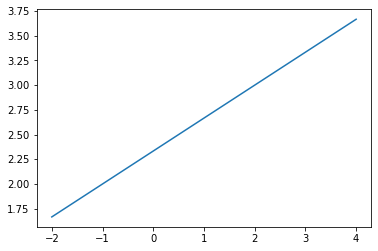

In [ ]:
a,b=solve(-1,5,2,4)
x=arange(-2,5)
plot(x,a+b*x)

In [ ]:
%pwd

'/Users/yoavfreund/projects/butons/XGBoost'

In [ ]:
import pickle as pk
with open('../data/172/BoostedTrees.pkl','bw') as pkl_file:
    pk.dump(bst_list,pkl_file)
!ls -lh ../data/172/*.pkl

-rw-r--r--  1 yoavfreund  staff   2.2M Aug 16 10:53 ../data/172/BoostedTrees.pkl
-rw-r--r--  1 yoavfreund  staff   221M Aug 14 14:54 ../data/172/extracted_cells.pkl


In [ ]:
def plot_margins(_train_size):
    plt.figure(figsize=(8, 6))
    for i in range(10):
        trainDM,testDM=split_data(df)
        legends=[]
        # Use early_stopping_rounds=5 to enable early stopping
        for num_round in [100]:
            bst = xgb.train(param, trainDM, num_round, evallist, verbose_eval=False)
            y_pred = bst.predict(testDM, iteration_range=[0,bst.best_ntree_limit], output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = xgbh.get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            xgbh.get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(X_train.shape[0]))
    plt.show()

In [ ]:
plot_margins(0.03)

In [ ]:
plot_margins(0.1)

In [ ]:
plot_margins(0.8)

## Per example variation analysis
The CDFs provide information on the variation of the aggregate. If we want to estimate of the confidence on a single examples we need to compute the variance **per example**

In [ ]:
data  = np.load("Data/processed_data_15mb.np")
data.shape

In [ ]:
def get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp, num_chunks=20):
    error_cuv_bin = np.array(np.array(error_cuv_samp) * num_chunks, dtype=int)
    error_cuv_bin[error_cuv_bin == num_chunks] = num_chunks - 1
    error_ger_bin = np.array(np.array(error_ger_samp) * num_chunks, dtype=int)
    error_ger_bin[error_ger_bin == num_chunks] = num_chunks - 1
    
    min_cuv = np.zeros(num_chunks, dtype=float)
    max_cuv = np.zeros(num_chunks, dtype=float)
    min_ger = np.zeros(num_chunks, dtype=float)
    max_ger = np.zeros(num_chunks, dtype=float)
    
    normalizing_factor = (max(thresholds_samp) - min(thresholds_samp))
    
    for i in range(num_chunks):
        min_cuv[i] = thresholds_samp[np.min(np.where(error_cuv_bin == i))]/normalizing_factor
        max_cuv[i] = thresholds_samp[np.max(np.where(error_cuv_bin == i))]/normalizing_factor
        min_ger[i] = thresholds_samp[np.min(np.where(error_ger_bin == i))]/normalizing_factor
        max_ger[i] = thresholds_samp[np.max(np.where(error_ger_bin == i))]/normalizing_factor
            
    return min_cuv, max_cuv, min_ger, max_ger

In [ ]:
def generate_samples(data, size=500, num_chunks=20):
    for i in range(200):
        if i == 0:
            min_cuv = np.zeros(num_chunks, dtype=float)
            max_cuv = np.zeros(num_chunks, dtype=float)
            min_ger = np.zeros(num_chunks, dtype=float)
            max_ger = np.zeros(num_chunks, dtype=float)
        
        #Sampling Random indices for selection
        samp_indices = np.random.randint(len(data), size=size)
        
        #Test data and labels
        X_samp = data[samp_indices, :-1]
        y_samp = np.array(data[samp_indices, -1], dtype=int)
        
        #Test predictions
        dsamp = xgb.DMatrix(X_samp, label=y_samp)    
        y_samp_pred = bst.predict(dsamp, iteration_range=[0,bst.best_ntree_limit], output_margin=True)

        thresholds_samp = sorted(np.unique(np.round(y_samp_pred, 2)))
        error_cuv_samp, error_ger_samp = xgbh.get_error_values(y_samp_pred, y_samp, thresholds_samp)
        
        min_cuv_samp, max_cuv_samp, min_ger_samp, max_ger_samp = get_error_ranges(error_cuv_samp, error_ger_samp, thresholds_samp)
        
        if i == 0:
            min_cuv = min_cuv_samp
            max_cuv = max_cuv_samp
            min_ger = min_ger_samp
            max_ger = max_ger_samp
        else:
            min_cuv[min_cuv > min_cuv_samp] = min_cuv_samp[min_cuv > min_cuv_samp]
            max_cuv[max_cuv < max_cuv_samp] = max_cuv_samp[max_cuv < max_cuv_samp]
            min_ger[min_ger > min_ger_samp] = min_ger_samp[min_ger > min_ger_samp]
            max_ger[max_ger < max_ger_samp] = max_ger_samp[max_ger < max_ger_samp]         
    
    for i in range(20):
        plt.plot([min_cuv[i], max_cuv[i]], [i/20.0, i/20.0], 'b')
        plt.plot([min_ger[i], max_ger[i]], [i/20.0, i/20.0], 'r')
    

* Each line segment represents the average man and std of a set of examples, stratified by thei score.

In [ ]:
plt.figure(figsize=(8, 6))
#legends = ['Cuviers', 'Gervais']

#Best thresholds from the ROC Analysis
thr_lower_index = np.min(np.where((tpr > 0.95)))
thr_upper_index = np.max(np.where((tpr  < 0.6)))
thr_lower, thr_upper = thresholds[thr_lower_index], thresholds[thr_upper_index]
thr_lower_norm = thr_lower/(np.max(thresholds) - np.min(thresholds))
thr_upper_norm = thr_upper/(np.max(thresholds) - np.min(thresholds))
print("Thresholds (lower, upper):", thr_lower_norm, thr_upper_norm)


generate_samples(data, num_chunks=20)

#xgbh.get_margin_plot(error_cuv_100, error_ger_100, thresholds_100, legends = legends, style=['y', 'g'])
plt.plot([thr_lower_norm, thr_lower_norm], [0, 1], 'm:')
plt.plot([thr_upper_norm, thr_upper_norm], [0, 1], 'm:')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlabel('Score')
plt.ylabel('CDF')
legends = ['Cuviers_100', 'Gervais_100']
plt.legend(legends)
plt.show()

# Summary
* We saw how PCA+Boosting are used to solve a real-world problem.

* We saw several ways to quantify and understand the behaviour of boosted trees.
   * Train and test error
   * Train and test loss
   * ROC curves
   * Stability of scores

* Next Time: **Neural Networks**